# JSLDS Jacobian Switching Linear Dynamical System - 3-bit memory experiment

This notebook walks through the experimental results presented for the 3-bit memory experiment in the paper.

### Imports

In [ ]:
# Numpy, JAX, and Matplotlib should all be correctly installed and on the 
# python path.
import time
import jax
from jax.experimental import optimizers
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np             # original CPU-backed NumPy
from sklearn.decomposition import PCA

In [ ]:
!git clone https://github.com/jimmysmith1919/JSLDS.git

In [ ]:
# You must change this to the location of the computation-thru-dynamics directory.
HOME_DIR = '/content/JSLDS'#'/Users/jamessmith/Google_Drive/Stanford/Research/JSLDS' #'/content/JSLDS'#'/Users/jamessmith/Google_Drive/Stanford/Research/JSLDS' 

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
import lfads_tutorial.lfads_autonomous as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize_autonomous import optimize_lfads, get_kl_warmup_fun

### Dependencies
To run this notebok you must upload the following files included in the supplement_code folder in the supplementary info zip file into the session storage (click the "files" folder on the left and then select "upload"):


*   model_and_training.py:  contains model and optimization code
*   nbit_memory_task.py:    functions to generate task inputs and targets
*   fixed_point_finding.py: functions to run the numerical fixed point finding
*   plotting.py:            some useful plotting functions



In [ ]:
import model_and_training as JSLDS
import nbit_memory_task as nbit
import plotting
import fixed_point_finding as num_fps

### Reload or train new model?
Upload the following file if you would like to load the trained JSLDS/cotrained RNN weights used for the experimental results in the paper:

* trained_params_jslds_nbit_memory_0.000209_2021-04-29_02_24_09.npz

Upload the following file if you would like to load the trained standard GRU weights used in the paper:

* trained_params_jslds_nbit_memory_0.000413_2021-04-28_20_08_37.npz

If you would like to load the trained JSLDS model weights from the paper set reload_trained_model = True. If you would like to train a new model set this variable to False.

In [ ]:
reload_trained_model = False

### 3-bit memory task definition

In [ ]:
# Nbit memory parameters
ntimesteps = 25
p = 0.3
flip_prob = np.array([(p / 2), (1 - p), (p / 2)])
nmem_inputs = 3
u = nmem_inputs * 2
o = nmem_inputs     # Number of outputs in the RNN

input_params = (ntimesteps, nmem_inputs, flip_prob)
nbit_memory_build_partial = lambda skeys: nbit.nbit_memory_build_inputs_and_targets(input_params,skeys)
nbit_memory_build_inputs_and_targets_jit = jax.jit(nbit_memory_build_partial)
build_inputs_and_targets = nbit_memory_build_inputs_and_targets_jit
input_plot_batch = nbit.nbit_memory_plot_batch

#set u_star (input to expand around in taylor approximation) to zeros (average of the inputs)
jslds_rnn = JSLDS.jslds_rnn_x_star_is_zeros

### Model Definition

### Use trained model
See the paper Appendix for the hyperparameters used for this model

In [ ]:
if reload_trained_model:
    network_path = 'trained_params_jslds_nbit_memory_0.000209_2021-04-29_02_24_09.npz'
    loaded_params = np.load(network_path, allow_pickle=True)
    params = loaded_params['arr_0'].item()

    batch_size = 256          # How many examples in each batch
    #If using trained model, do not change the following parameters
    n = 100             # Number of units in the RNN
    rnn_fun = JSLDS.gru
    rnn_hps = {'fun' : rnn_fun}  
    hps = { 'rnn' : rnn_hps}

### Train a new model
See the paper Appendix for a more detailed discussion of how to think about the 4 JSLDS loss/regularization strength parameters. Note that if you would like to train a standard RNN (without co-training with a JSLDS), you can simply set:
*   fp_reg = 0.0
*   out_nl_reg = 1.0
*   out_staylor_reg = 0.0
*   taylor_reg = 0.0 



In [ ]:
if not reload_trained_model:
    # RNN hyperparameters
    n = 100                      # Number of units in the RNN
    rnn_params_fun = JSLDS.gru_params
    rnn_fun = JSLDS.gru
    taylor_series_rnn_order = 1  # Taylor series expansion order

    i_factor = 1.0               # input scale
    h_factor = 0.9               # Scaling of the recurrent weight matrix
    recurrent_is_identity = False
    h_scale = 0.1          
    rnn_hps = {'u' : u, 'n' : n, 
               'recurrent_is_identity' : recurrent_is_identity, 
              'h_factor' : h_factor, 
              'h_scale' : h_scale, 'i_factor' : i_factor,
              'params_fun' : rnn_params_fun, 
              'fun' : rnn_fun, 'order' : taylor_series_rnn_order}  
    nlayers = 2     # of MLP layers
    hps = {'mlp' : {'nlayers' : nlayers, 'n' : n}, 
          'rnn' : rnn_hps, 
          'out' : {'u' : n, 'o' : o, 'i_factor' : 1.0}}


    # Optimization hyperparameters
    num_batchs = 40000        # Total number of batches to train on.
    batch_size = 256          # How many examples in each batch
    eval_batch_size = 1024    # Evaluation batch size
    step_size = 0.02          # initial learning rate
    decay_factor = 0.9999     # decay the learning rate this much
    max_grad_norm = 10.0      # max gradient norm before clipping
    adam_b1 = 0.9             # Adam parameters
    adam_b2 = 0.999
    adam_eps = 1e-1
    print_every = 500         # Print training information every so often

    l2_reg = 0.0             # amount of L2 regularization on the weights

    # These four HPS dictate how the JSLDS is trained up. 
    fp_reg = 100.0         # fixed point regularizer strength
    out_nl_reg = 3.0       # nonlinear RNN loss strength
    out_staylor_reg = 1.0  # JSLDS loss strength
    taylor_reg = 10.0      # approximation regularizer strength

    opt_hps = {'num_batches' : num_batchs, 'batch_size' : batch_size, 
              'eval_batch_size' : eval_batch_size, 'print_every' : print_every,
              'step_size' : step_size, 'decay_factor' : decay_factor, 
              'max_grad_norm' : max_grad_norm, 
              'out_nl_reg': out_nl_reg, 'out_staylor_reg' : out_staylor_reg,
              'l2_reg' : l2_reg, 'fp_reg' : fp_reg, 'taylor_reg' : taylor_reg, 
              'adam_b1' : adam_b1, 'adam_b2': adam_b2, 'adam_eps': adam_eps}



Run this next cell regardless if you are loading the trained model or training a new model. This cell defines the initial random seed, plots an example trial, and defines a couple of useful functions that will be used later. The first time running this cell may take a few minutes during the first jit'ed call.

Seed: 1920


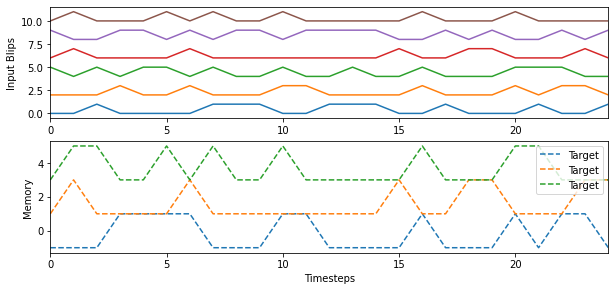

In [ ]:
# Plot input/target example and define batch RNN function

seed = 1920
print("Seed: %d" % seed)
key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot input/target examples
ntoplot = 20    # how many example one could view 

key, skey = jax.random.split(key, 2)
skeys = jax.random.split(skey, ntoplot) # get ntoplot random keys
inputs, targets, masks = build_inputs_and_targets(skeys)
# Plot the input to the RNN and the target for the RNN.
input_plot_batch(ntimesteps, inputs, targets)


def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        build_inputs_and_targets(keys)
    h0s_b = None # Use trained h0
    return inputs_b, targets_b, masks_b, h0s_b


batch_rnn_run = JSLDS.get_batch_rnn_run_fun(hps['rnn']['fun'], jslds_rnn)

This next cell is only necessary if you are training a new model. It initializes the model weights and plots the evaluation of the untrained networks on example trials using the initial random weights. It shows samples of the example inputs, sample JSLDS and RNN states (the approximation quality), sample expansion points and the RNN evaluated at the expansion points (the fixed point approximation quality), and sample JSLDS and RNN outputs compared to the target.

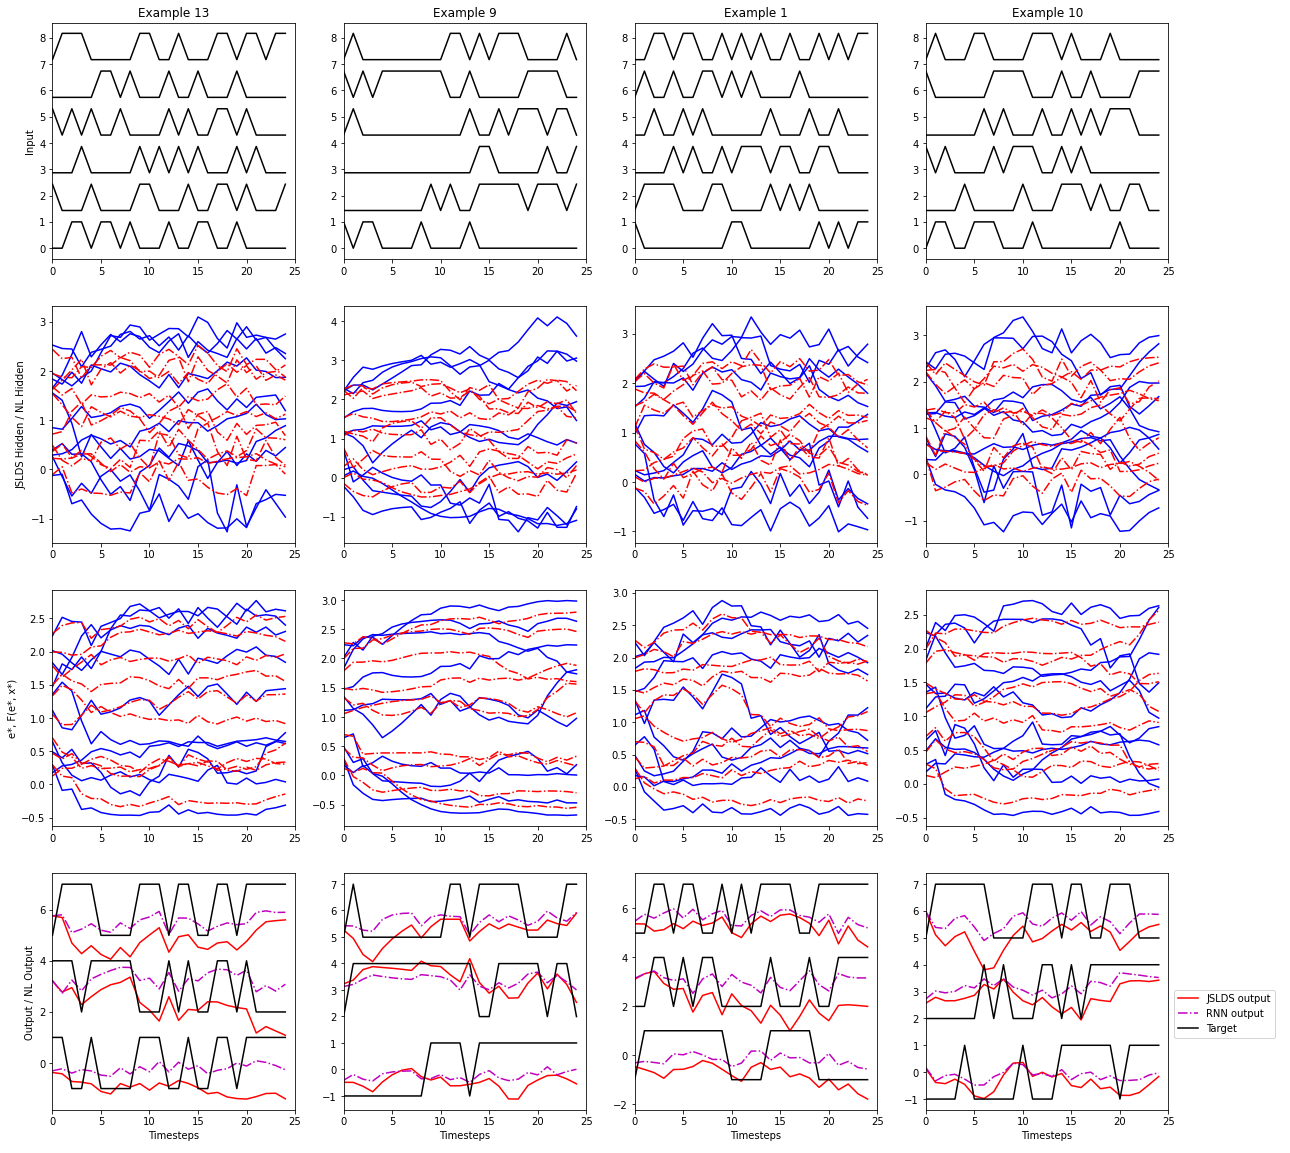

In [ ]:
if not reload_trained_model:
    # Init some parameters for training.
    key, subkey = jax.random.split(key, 2)
    init_params = JSLDS.jslds_rnn_params(subkey, **hps)
    rnn_run = lambda inputs: batch_rnn_run(init_params, inputs)

    key, skey = jax.random.split(key)
    rnn_internals = JSLDS.run_trials(rnn_run, inputs_targets_no_h0s, 
                                     1, 16, skey)
    key, skey = jax.random.split(key)
    plotting.plot_examples(ntimesteps, rnn_internals, skey, nexamples=4)

This next cell is only necessary if you are training a new model. It defines and plots the learning rate decay function.

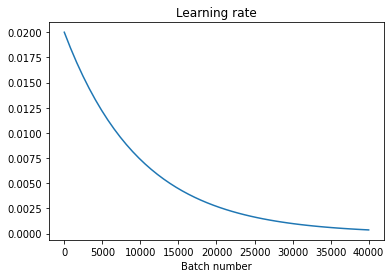

In [ ]:
if not reload_trained_model:
    # Create a decay function for the learning rate
    decay_fun = optimizers.exponential_decay(opt_hps['step_size'], 
                                            decay_steps=1, 
                                            decay_rate=opt_hps['decay_factor'])

    plt.figure()
    plt.subplot(111)
    batch_idxs = np.linspace(1, num_batchs)
    plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
    plt.axis('tight')
    plt.xlabel('Batch number')
    plt.title('Learning rate');

Run this cell to train a new JSLDS-RNN system. Should take ~20 minutes using Co-lab GPUs

In [ ]:
if not reload_trained_model:
    # Run the optimization loop, first jit'd call will take a minute.
    all_train_losses = []

    opt_init, opt_update, opt_get_params = \
        optimizers.adam(decay_fun, opt_hps['adam_b1'], opt_hps['adam_b2'], 
                        opt_hps['adam_eps'])
    opt_state = opt_init(init_params)
    start_time = time.time()


    for batch_idx in range(num_batchs):
        key, skey = jax.random.split(key)
        skeys = jax.random.split(skey, batch_size)
        inputs, targets, masks = build_inputs_and_targets(skeys)
        opt_state = JSLDS.update_w_gc_jit(batch_idx, opt_state, opt_update, 
                                          opt_get_params, inputs,
                                    targets, masks, opt_hps['max_grad_norm'], 
                                    opt_hps['out_nl_reg'], opt_hps['out_staylor_reg'],
                                    opt_hps['taylor_reg'], opt_hps['fp_reg'], 
                                    opt_hps['l2_reg'], 
                                    hps['rnn']['fun'], jslds_rnn)
        if batch_idx % print_every == 0:
            params = opt_get_params(opt_state)
            all_train_losses.append(JSLDS.loss_jit(params, inputs, targets, 
                                                   masks,
                                            opt_hps['out_nl_reg'],
                                            opt_hps['out_staylor_reg'],
                                            opt_hps['taylor_reg'], 
                                            opt_hps['fp_reg'], 
                                            opt_hps['l2_reg'], 
                                            hps['rnn']['fun'], jslds_rnn))
            train_loss = all_train_losses[-1]['total']
            batch_time = time.time() - start_time
            step_size = decay_fun(batch_idx)
            s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
            print(s.format(batch_idx, batch_time, step_size, train_loss))
            start_time = time.time()
            
    # List of dicts to dict of lists
    all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Batch 0 in 90.93 sec, step size: 0.02000, training loss 16.9421
Batch 500 in 17.53 sec, step size: 0.01902, training loss 0.3264
Batch 1000 in 17.50 sec, step size: 0.01810, training loss 0.1149
Batch 1500 in 17.51 sec, step size: 0.01721, training loss 0.0556
Batch 2000 in 17.50 sec, step size: 0.01637, training loss 0.0355
Batch 2500 in 17.51 sec, step size: 0.01558, training loss 0.0258
Batch 3000 in 17.50 sec, step size: 0.01482, training loss 0.0207
Batch 3500 in 17.51 sec, step size: 0.01409, training loss 0.0173
Batch 4000 in 17.50 sec, step size: 0.01341, training loss 0.0150
Batch 4500 in 17.50 sec, step size: 0.01275, training loss 0.0132
Batch 5000 in 17.50 sec, step size: 0.01213, training loss 0.0115
Batch 5500 in 17.53 sec, step size: 0.01154, training loss 0.0105
Batch 6000 in 17.51 sec, step size: 0.01098, training loss 0.0098
Batch 6500 in 17.50 sec, step size: 0.01044, training loss 0.0090
Batch 7000 in 17.52 sec, step size: 0.00993, training loss 0.0084
Batch 7500 in

Plot the training results

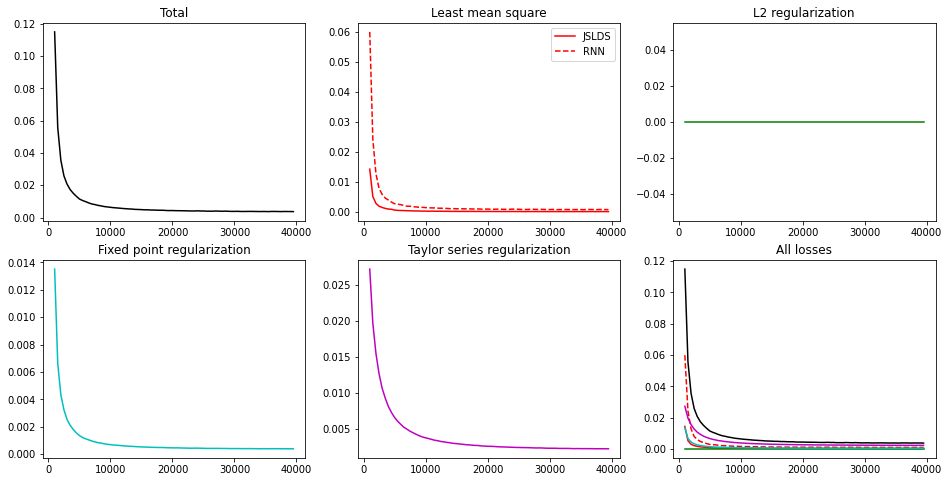

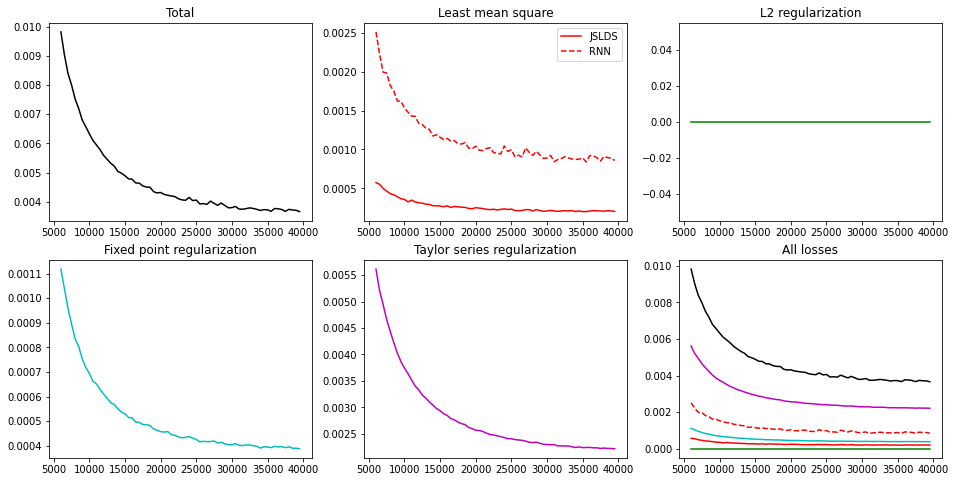

In [ ]:
if not reload_trained_model:
    # Show the loss through training.
    x = np.arange(0, num_batchs, print_every)
    for xl1,xl2 in [(1000, num_batchs), (6000, num_batchs)]:
        xl1 = int(xl1/print_every)
        xl2 = int(xl2/print_every)

        plt.figure(figsize=(16,8))
        plt.subplot(231)
        plt.plot(x[xl1:xl2], all_train_losses['total'][xl1:xl2], 'k')
        plt.title('Total')

        plt.subplot(232)
        plt.plot(x[xl1:xl2], all_train_losses['lms_jslds'][xl1:xl2], 'r')
        plt.plot(x[xl1:xl2], all_train_losses['lms_nl'][xl1:xl2], 'r--')

        plt.legend(('JSLDS', 'RNN'))
        plt.title('Least mean square')

        plt.subplot(233)

        plt.plot(x[xl1:xl2], all_train_losses['l2'][xl1:xl2], 'g');
        plt.title('L2 regularization')

        plt.subplot(234)
        plt.plot(x[xl1:xl2], all_train_losses['fixed_point'][xl1:xl2], 'c');
        plt.title('Fixed point regularization')

        plt.subplot(235)
        plt.plot(x[xl1:xl2], all_train_losses['taylor'][xl1:xl2], 'm');
        plt.title('Taylor series regularization')


        plt.subplot(236)
        plt.plot(x[xl1:xl2], all_train_losses['total'][xl1:xl2], 'k')
        plt.plot(x[xl1:xl2], all_train_losses['lms_jslds'][xl1:xl2], 'r')
        plt.plot(x[xl1:xl2], all_train_losses['lms_nl'][xl1:xl2], 'r--')
        plt.plot(x[xl1:xl2], all_train_losses['l2'][xl1:xl2], 'g')
        plt.plot(x[xl1:xl2], all_train_losses['fixed_point'][xl1:xl2], 'c')
        plt.plot(x[xl1:xl2], all_train_losses['taylor'][xl1:xl2], 'm')
        plt.title('All losses');

Evaluate loss on a held-out set of trials. This can be computed for the uploaded trained model or the newly trained model. 

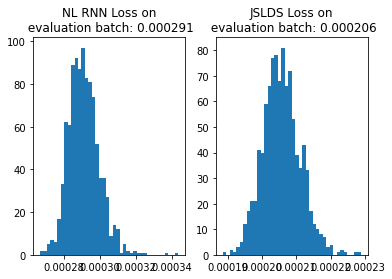

In [ ]:
# Take a batch for an evaluation loss, notice all penalties are 0 for 
#the evaluation, except for the relevant task penalty

if not reload_trained_model:
    params = opt_get_params(opt_state)

key, skey = jax.random.split(key)

ntries = 1000
eval_losses = np.zeros(ntries)
eval_losses_j = np.zeros(ntries)
for try_idx in range(ntries):
    key, subkey = jax.random.split(key, 2)
    skeys = jax.random.split(subkey, batch_size)
    inputs, targets, masks = build_inputs_and_targets(skeys)
    eval_loss = JSLDS.loss_jit(params, inputs, targets, masks,
                         1.0,
                         0.0,
                         0.0, 0.0, 0.0, 
                         hps['rnn']['fun'], jslds_rnn)['total']
    eval_losses[try_idx] = eval_loss
    eval_loss_j = JSLDS.loss_jit(params, inputs, targets, masks,
                      0.0,
                      1.0,
                      0.0, 0.0, 0.0, 
                      hps['rnn']['fun'],jslds_rnn)['total']
    eval_losses_j[try_idx] = eval_loss_j


plt.subplot(121)
eval_loss_mean = np.mean(eval_losses)
eval_loss_str = "{:.6f}".format(eval_loss_mean)
plt.title("NL RNN Loss on\n evaluation batch: %s" % (eval_loss_str))    
plt.hist(eval_losses, 40);

plt.subplot(122)
eval_loss_mean_j = np.mean(eval_losses_j)
eval_loss_str_j = "{:.6f}".format(eval_loss_mean_j)
plt.title("JSLDS Loss on\n evaluation batch: %s" % (eval_loss_str_j))    
plt.hist(eval_losses_j, 40);

Compare the loss of the co-trained nonlinear RNN (left) and the JSLDS (right)

### Visualizations of trained JSLDS-RNN system

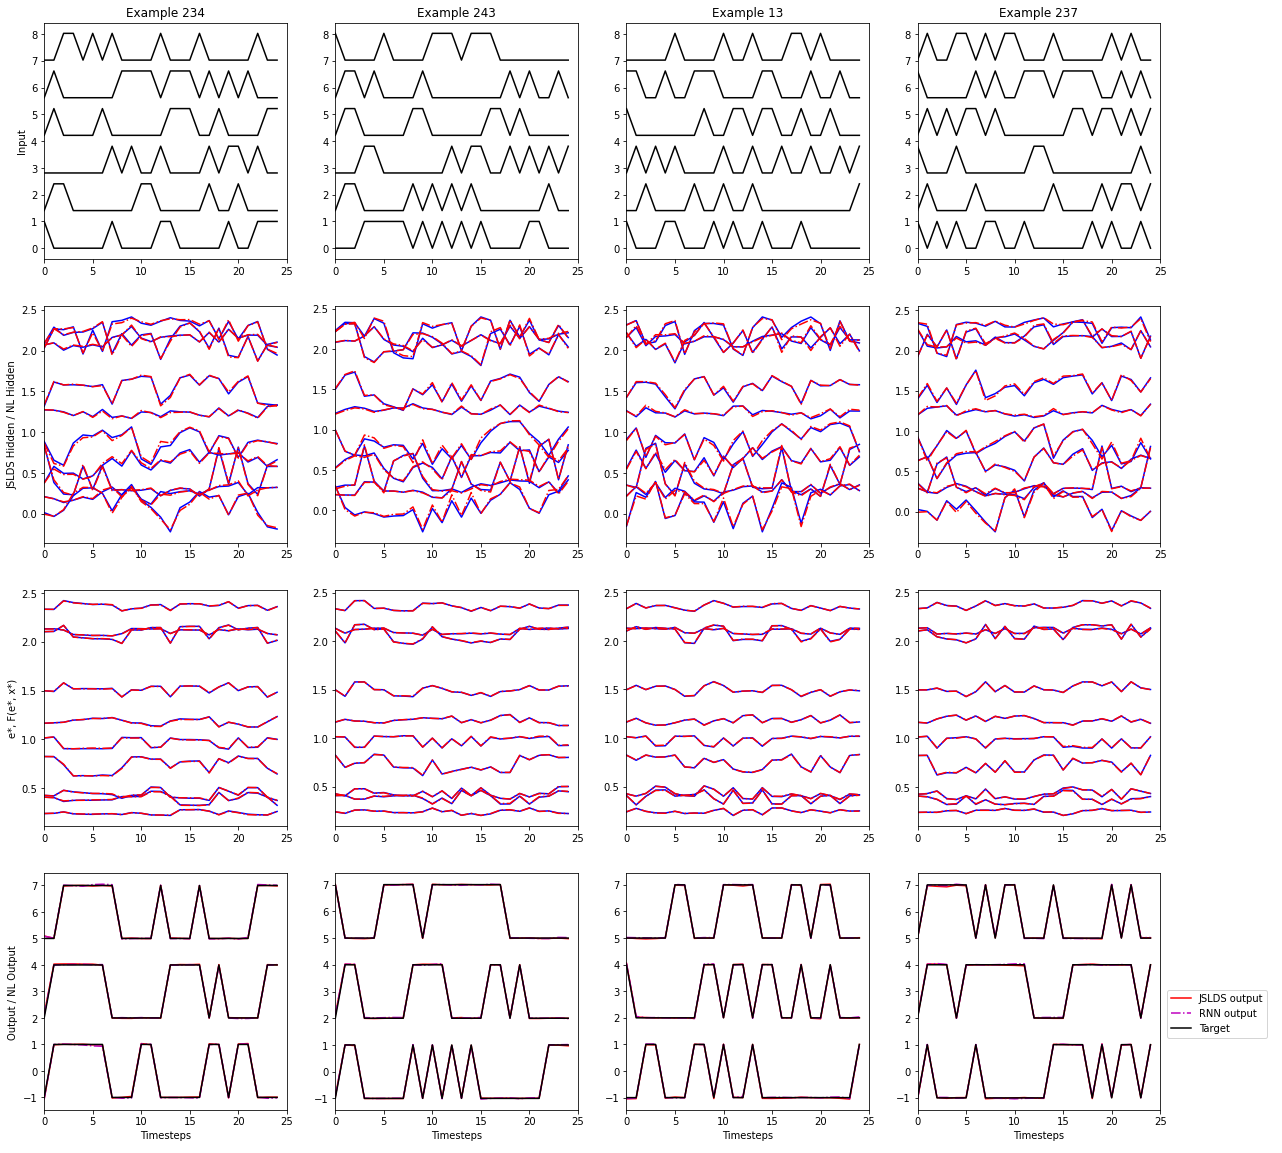

In [ ]:
# Visualize how well the trained models perform.

rnn_run = lambda inputs: batch_rnn_run(params, inputs)


key, skey = jax.random.split(key)
rnn_internals = JSLDS.run_trials(rnn_run, inputs_targets_no_h0s, 1, batch_size, skey)

key, skey = jax.random.split(key)
plotting.plot_examples(ntimesteps, rnn_internals, skey, nexamples=4)

In [ ]:
#Helpful functions for viewing the results
def get_apply_readout(params):
  def apply_readout(states_dn):
    return (np.dot(params['out']['W'], states_dn.T) + 
            np.expand_dims(params['out']['b'], axis=1)).T
  return apply_readout


def readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3, fs):
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    ax.legend(loc='upper right',prop={'size': fs}, frameon=False)
    ax.set_xlabel(axlabel1, fontsize=fs)
    ax.set_ylabel(axlabel2, fontsize=fs)
    ax.set_zlabel(axlabel3, fontsize=fs)
    ax.set_title(title, fontsize=fs)
    return ax


def pca_plot_settings(ax,fs):
    ax.set_xlabel('PC #1', fontsize=fs)
    ax.set_ylabel('PC #2', fontsize=fs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='lower left',fontsize=fs, frameon=False)

### JSLDS/Co-trained RNN output trajectories in readout space

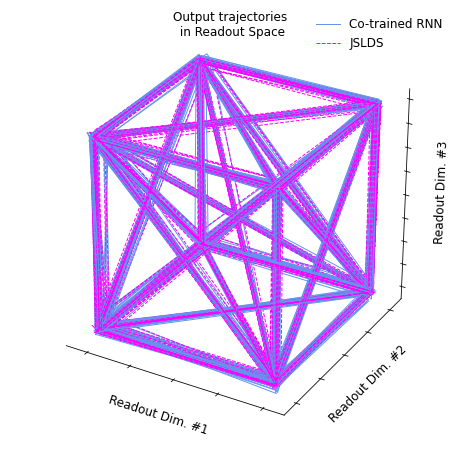

In [ ]:
apply_readout = get_apply_readout(params)

fs = 12
jslds_color='magenta'
rnn_color = 'cornflowerblue'
rnn_linewidth = 1
jslds_linewidth = 1

ntoplot = 100
hiddens = np.reshape(rnn_internals['hiddens'][:ntoplot], (-1, n))
nl_hiddens = np.reshape(rnn_internals['nl_hiddens'][:ntoplot], (-1, n))

h_pca = apply_readout(hiddens)
nlh_pca = apply_readout(nl_hiddens)
axlabel1 = 'Readout Dim. #1'
axlabel2 = 'Readout Dim. #2'
axlabel3 = 'Readout Dim. #3'
title = 'Output trajectories\n in Readout Space'
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

nexamples = ntoplot
for eidx in range(nexamples):
    start_idx = eidx * ntimesteps
    stop_idx = (eidx + 1) * ntimesteps
    ax.plot3D(nlh_pca[start_idx:stop_idx,0], nlh_pca[start_idx:stop_idx,1], 
              nlh_pca[start_idx:stop_idx,2], color=rnn_color, 
              linewidth = rnn_linewidth)
    
    ax.plot3D(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], 
              h_pca[start_idx:stop_idx,2], '--', color=jslds_color, 
              linewidth=jslds_linewidth)

ax.plot3D(nlh_pca[start_idx:stop_idx,0], nlh_pca[start_idx:stop_idx,1], 
          nlh_pca[start_idx:stop_idx,2], label='Co-trained RNN',
          color=rnn_color,linewidth = rnn_linewidth)
ax.plot3D(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], 
          h_pca[start_idx:stop_idx,2], '--', color=jslds_color, 
          label='JSLDS', linewidth=jslds_linewidth)

readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3, fs)

### JSLDS Expansion points in readout space

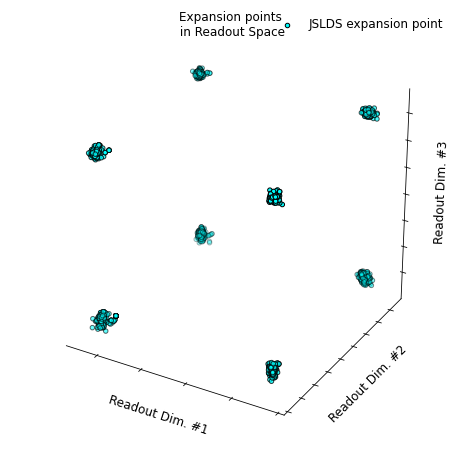

In [ ]:
exp_color = 'cyan'
rnn_linewidth = 1.4
jslds_linewidth = 1.2

ntoplot = 100
hstars = np.reshape(rnn_internals['h_stars'][:ntoplot], (-1, n))

hstar_pca = apply_readout(hstars)
axlabel1 = 'Readout Dim. #1'
axlabel2 = 'Readout Dim. #2'
axlabel3 = 'Readout Dim. #3'
title = 'Expansion points\n in Readout Space'

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
emax = h_pca.shape[0]
ax.scatter(hstar_pca[:emax,0], hstar_pca[:emax,1], hstar_pca[:emax,2], 
            s=20, color=exp_color,label='JSLDS expansion point', 
           edgecolors='black',zorder=0);

readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3,fs)

The expansion points have learned to cluster around 8 marginally stable (determined by eigenvalue analysis below) fixed points of the nonlinear RNN. (See comparison with numerical fixed points below for verification.)

For any trial, we can analyze eigenvalues of JSLDS at any point in its state space by
computing an eigendecomposition of the co-trained RNN's recurrent Jacobian 
at corresponding expansion point. 

In [ ]:
#Compute Jacobian at each expansion point for a given trial

trial = 5 #trial from evaluation trials of size batch_size

x_star = np.zeros(u)
rnn_fun_h = lambda h : rnn_fun(params['rnn'], h, x_star)

hstar_jac = num_fps.compute_jacobians(rnn_fun_h, rnn_internals['h_stars'][trial]
                                      )
hstar_eig_decomps = num_fps.compute_eigenvalue_decomposition(hstar_jac,
                                                             'magnitude')

Top ten eigenvalues:
 [1.020672  +0.j         1.0148635 +0.j         0.9934174 +0.j
 0.8896977 +0.j         0.81728256+0.j         0.76190305+0.01466883j
 0.76190305-0.01466883j 0.72265637-0.06972723j 0.72265637+0.06972723j
 0.70051825+0.03125578j]


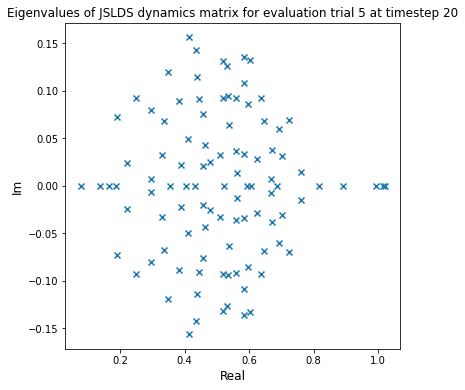

In [ ]:
#Plot eigenvalues in complex plane for specific timestep of trial
timestep = 20

plt.figure(figsize=(6,6))
example = hstar_eig_decomps[timestep]['evals'][:]
X = [x.real for x in example]
Y = [x.imag for x in example]
plt.scatter(X,Y, marker='x', alpha=1)
plt.xlabel('Real', fontsize=fs)
plt.ylabel('Im', fontsize=fs)
plt.title('Eigenvalues of JSLDS dynamics matrix for evaluation trial {} at timestep {}'.format(trial, timestep))

print('Top ten eigenvalues:\n', hstar_eig_decomps[timestep]['evals'][:10])

### JSLDS approximation of co-trained RNN's dynamics

Here we evaluate the JSLDS approximation of the co-trained nonlinear RNN's dynamics. We first display example trajectories projected into PCA space. Note the JSLDS states were computed by running the JSLDS forward in time for the entire trial trajectory, as opposed to needing to resort to one-step ahead dynamics generation.

In [ ]:
#Compute PCA
pca = PCA(n_components=2).fit(rnn_internals['nl_hiddens'].reshape(-1,n))
h_pca = pca.transform(rnn_internals['hiddens'].reshape(-1,n))
nlh_pca = pca.transform(rnn_internals['nl_hiddens'].reshape(-1,n))

Text(0.5, 1.0, 'Trial 11 JSLDS dynamics generation')

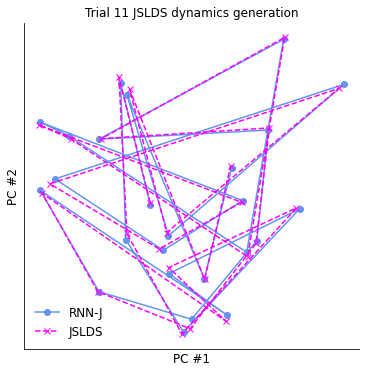

In [ ]:
#Plot PCA trajectories for example trial
trial = 11
plt.figure(figsize=(6,6))
start_idx = trial*25
stop_idx = trial*25+25

ax=plt.subplot(111)


ax.plot(nlh_pca[start_idx:stop_idx,0], nlh_pca[start_idx:stop_idx,1], '-o', 
        color='cornflowerblue', label='RNN-J')
ax.plot(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], '--x', 
        color='magenta', label='JSLDS')
pca_plot_settings(ax,fs)
plt.title('Trial {} JSLDS dynamics generation'.format(trial), fontsize=fs)

Now compute the mean squared error for the approximation on a batch of evaluation trials

In [ ]:
#Compute evaluation batch mean squared error
approx_mse = np.sum((rnn_internals['hiddens']-rnn_internals['nl_hiddens'])**2
                    )/(batch_size*ntimesteps*n)

print('Evaluation batch mean squared error: {0:.4}'.format(approx_mse))

Evaluation batch mean squared error: 0.000222


### Numerically find the fixed points of the co-trained RNN for verification.

Now we use the numerical fixed point methods to check that the expansion points learned by the JSLDS approximate the co-trained RNN's fixed points.

Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-500 in 1.04 sec, Step size: 0.77875, Training loss 0.00003
    Batches 501-1000 in 0.64 sec, Step size: 0.60645, Training loss 0.00002
    Batches 1001-1500 in 0.64 sec, Step size: 0.47228, Training loss 0.00001
    Batches 1501-2000 in 0.64 sec, Step size: 0.36779, Training loss 0.00001
    Batches 2001-2500 in 0.64 sec, Step size: 0.28642, Training loss 0.00001
    Batches 2501-3000 in 0.64 sec, Step size: 0.22305, Training loss 0.00001
    Batches 3001-3500 in 0.64 sec, Step size: 0.17370, Training loss 0.00001
    Batches 3501-4000 in 0.64 sec, Step size: 0.13527, Training loss 0.00001
    Batches 4001-4500 in 0.64 sec, Step size: 0.10534, Training loss 0.00001
    Batches 4501-5000 in 0.64 sec, Step size: 0.08203, Training loss 0.00001
    Batches 5001-5500 in 0.64 sec, Step size: 0.06388, Training loss 0.00001
    Batches 5501-6000 in 0.64 sec, Step size: 0.04975, Training loss 0.00001
    Batc

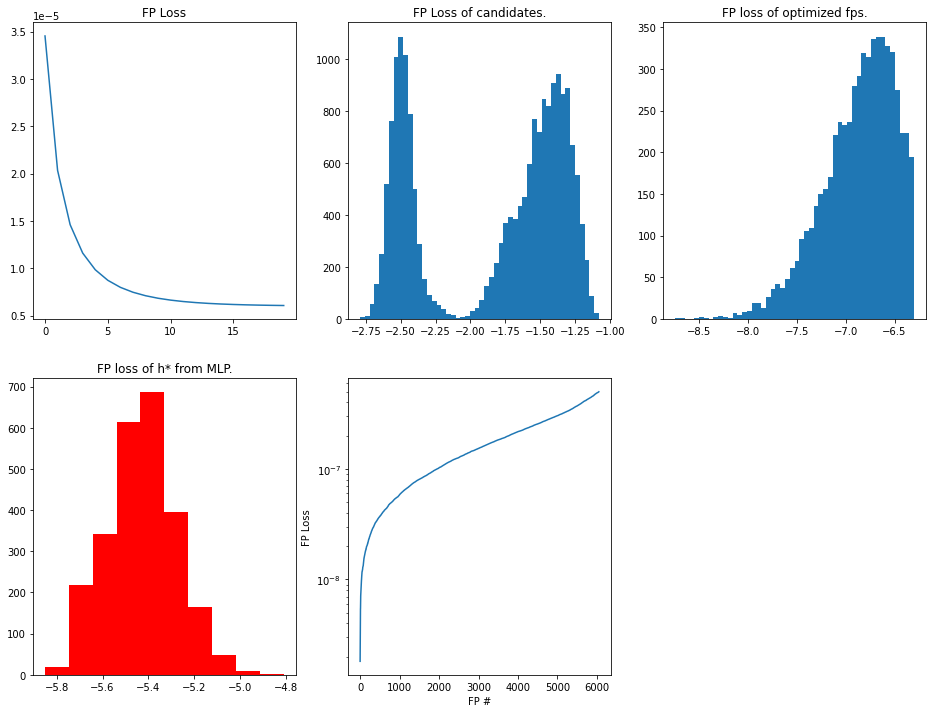

In [ ]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000     # Total number of batches to train on.
fp_batch_size = 128        # How many examples in each batch
fp_step_size = 1.0         # initial learning rate
fp_decay_factor = 0.9995   # decay the learning rate this much
fp_decay_steps = 1         
fp_adam_b1 = 0.9           # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5

fp_noise_var = 0.01        # Gaussian noise added to fixed point candidates
fp_opt_print_every = 500   # Print training information during optimiziation 
fp_opt_stop_tol = 0.0
fp_tol = 0.0000005

fp_unique_tol = 0.0         # tolerance for determination of identical fixed pts
fp_outlier_tol = np.inf     # define outlier tolerance

fp_opt_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 
              'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : fp_opt_stop_tol, 
              'fp_tol' : fp_tol, 'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}

x_star = np.zeros(u)
rnn_fun_h = lambda h : rnn_fun(params['rnn'], h, x_star)


batch_rnn_fun_h = jax.vmap(rnn_fun_h, in_axes=(0,))
fp_loss_fun = num_fps.get_fp_loss_fun(rnn_fun_h)
total_fp_loss_fun = num_fps.get_total_fp_loss_fun(rnn_fun_h)


fp_candidates1 = np.reshape(rnn_internals['h_stars'], (-1, n))
fp_candidates2 = np.reshape(rnn_internals['hiddens'], (-1, n))
fp_candidates3 = np.reshape(rnn_internals['nl_hiddens'], (-1, n))
fp_candidates = np.concatenate([fp_candidates1, fp_candidates2, fp_candidates3], 
                               axis=0)

fps, fp_losses, fp_idxs, fp_opt_details = \
    num_fps.find_fixed_points(rnn_fun_h, fp_candidates, fp_opt_hps, 
                              do_print=True)


plt.figure(figsize=(16,12))
plt.subplot(231)
plt.plot(fp_opt_details['fp_losses'])
plt.title('FP Loss')
plt.subplot(232)
plt.hist(np.log10(fp_loss_fun(fp_candidates)), 50)
plt.title('FP Loss of candidates.')
plt.subplot(233)
plt.hist(np.log10(fp_loss_fun(fps)), 50);
plt.title('FP loss of optimized fps.')
plt.subplot(234)
plt.hist(np.log10(fp_loss_fun(hstars)), color='r');
plt.title('FP loss of h* from MLP.');
plt.subplot(235)
plt.semilogy(fp_losses)
plt.xlabel('FP #')
plt.ylabel('FP Loss');

Now project the numerical fixed points into the readout space to compare to the expansion points

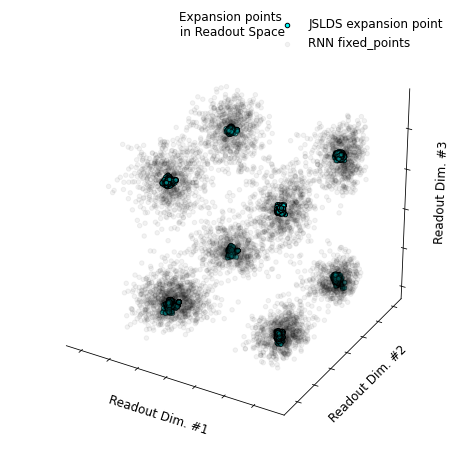

In [ ]:
exp_color = 'cyan'
rnn_linewidth = 1.4
jslds_linewidth = 1.2

ntoplot = 256
hstars = np.reshape(rnn_internals['h_stars'][:ntoplot], (-1, n))


hstar_pca = apply_readout(hstars)
fps_pca  = apply_readout(fps)
axlabel1 = 'Readout Dim. #1'
axlabel2 = 'Readout Dim. #2'
axlabel3 = 'Readout Dim. #3'
title = 'Expansion points\n in Readout Space'


fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')



emax = h_pca.shape[0]
ax.scatter(hstar_pca[:emax,0], hstar_pca[:emax,1], hstar_pca[:emax,2], 
            s=20, color=exp_color,label='JSLDS expansion point',
            edgecolors='black',zorder=0);
es = np.arange(fps.shape[0])
ax.scatter(fps_pca[es,0], fps_pca[es,1], fps_pca[es,2], 
            s=20, color='k',label='RNN fixed_points', alpha=0.05);

readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3,fs)

We see the expansion points provide a good approximation of the the co-trained RNN's fixed points.

### Compare to standard GRU

Load trained standard GRU trained without JSLDS

In [ ]:
network_path = 'trained_params_jslds_nbit_memory_0.000413_2021-04-28_20_08_37.npz'
loaded_params2 = np.load(network_path, allow_pickle=True)
params2 = loaded_params2['arr_0'].item()

Evaluate loss on a held-out set of trials.

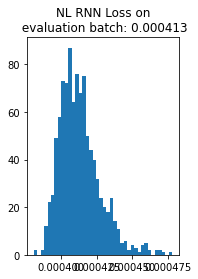

In [ ]:
key, skey = jax.random.split(key)

ntries = 1000
eval_losses = np.zeros(ntries)
for try_idx in range(ntries):
    key, subkey = jax.random.split(key, 2)
    skeys = jax.random.split(subkey, batch_size)
    inputs, targets, masks = build_inputs_and_targets(skeys)
    eval_loss = JSLDS.loss_jit(params2, inputs, targets, masks,
                         1.0,
                         0.0,
                         0.0, 0.0, 0.0, 
                         hps['rnn']['fun'], jslds_rnn)['total']
    eval_losses[try_idx] = eval_loss


plt.subplot(121)
eval_loss_mean = np.mean(eval_losses)
eval_loss_str = "{:.6f}".format(eval_loss_mean)
plt.title("NL RNN Loss on\n evaluation batch: %s" % (eval_loss_str))    
plt.hist(eval_losses, 40);

### Visualizations of standard trained GRU

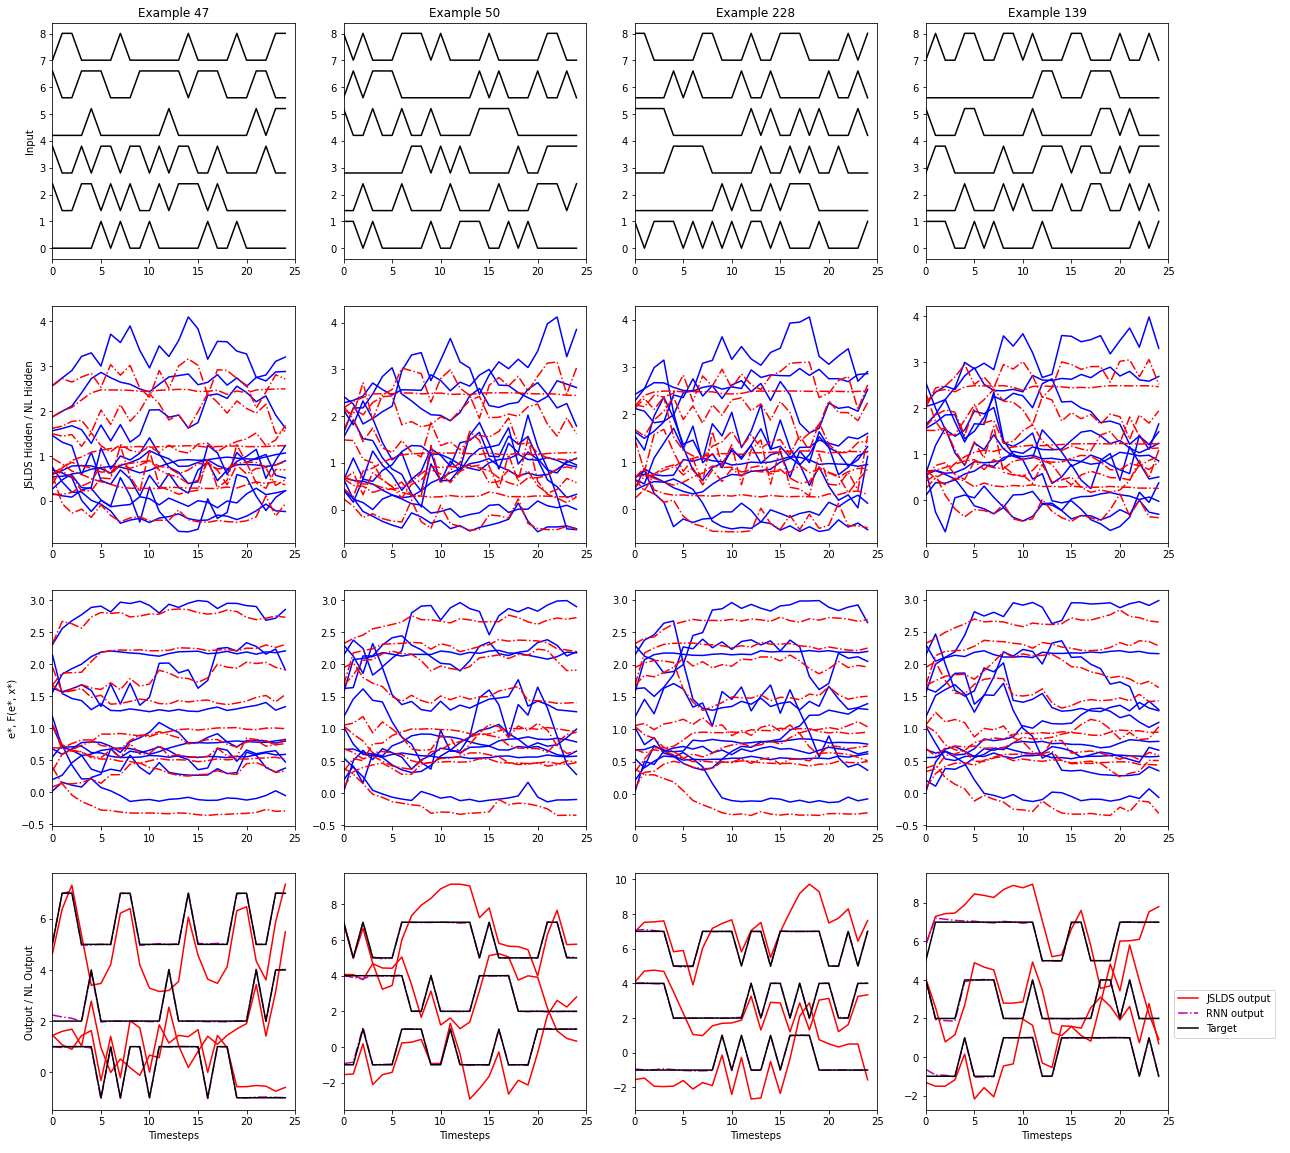

In [ ]:
# Visualize how well the trained models perform.

rnn_run2 = lambda inputs: batch_rnn_run(params2, inputs)


key, skey = jax.random.split(key)
rnn_internals2 = JSLDS.run_trials(rnn_run2, inputs_targets_no_h0s, 1,
                                  batch_size, skey)

key, skey = jax.random.split(key)
plotting.plot_examples(ntimesteps, rnn_internals2, skey, nexamples=4)

Note the JSLDS output and approximations above are all bad since the standard GRU was not co-trained with the JSLDS. So only the RNN output lines are relevant.

### Numerically find the fixed points of the standard GRU.

Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-500 in 0.88 sec, Step size: 0.77875, Training loss 0.00013
    Batches 501-1000 in 0.64 sec, Step size: 0.60645, Training loss 0.00007
    Batches 1001-1500 in 0.63 sec, Step size: 0.47228, Training loss 0.00005
    Batches 1501-2000 in 0.63 sec, Step size: 0.36779, Training loss 0.00004
    Batches 2001-2500 in 0.64 sec, Step size: 0.28642, Training loss 0.00003
    Batches 2501-3000 in 0.63 sec, Step size: 0.22305, Training loss 0.00003
    Batches 3001-3500 in 0.63 sec, Step size: 0.17370, Training loss 0.00002
    Batches 3501-4000 in 0.63 sec, Step size: 0.13527, Training loss 0.00002
    Batches 4001-4500 in 0.63 sec, Step size: 0.10534, Training loss 0.00002
    Batches 4501-5000 in 0.63 sec, Step size: 0.08203, Training loss 0.00002
    Batches 5001-5500 in 0.63 sec, Step size: 0.06388, Training loss 0.00002
    Batches 5501-6000 in 0.63 sec, Step size: 0.04975, Training loss 0.00002
    Batc

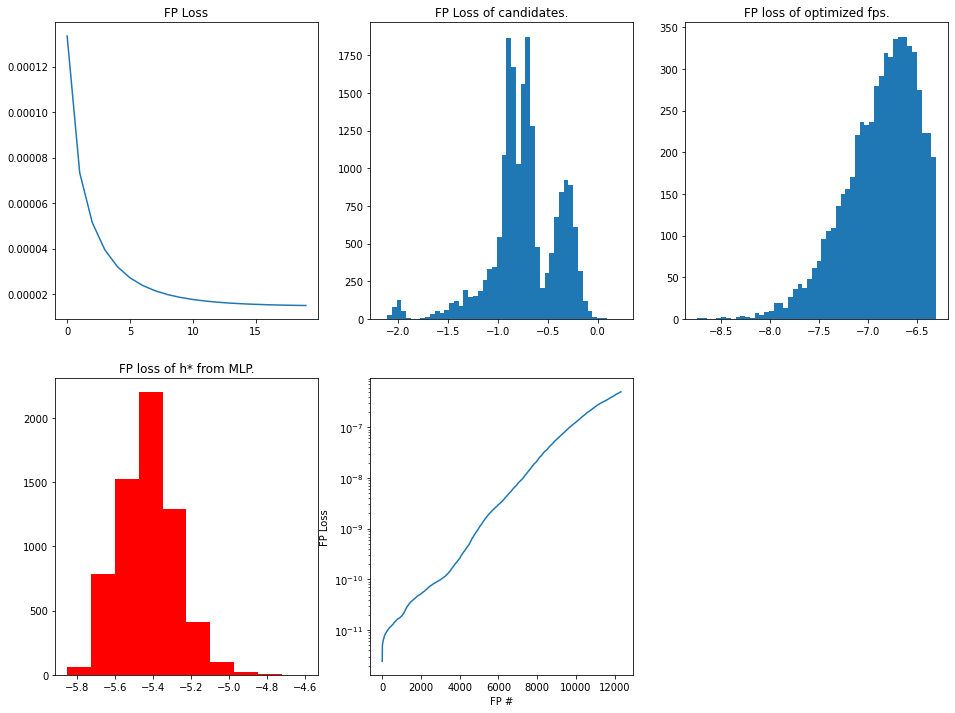

In [ ]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000         # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 1.0          # initial learning rate
fp_decay_factor = 0.9995     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5

fp_noise_var = 0.01          # Gaussian noise added to fixed point candidates 
fp_opt_print_every = 500   # Print training information during optimziation 
fp_opt_stop_tol = 0.0
fp_tol = 0.0000005

fp_unique_tol = 0.0         # tolerance for determination of identical fixed pts
fp_outlier_tol = np.inf     # define outlier tolerance

fp_opt_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 
              'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : fp_opt_stop_tol, 
              'fp_tol' : fp_tol, 'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}

x_star = np.zeros(u)
rnn_fun_h2 = lambda h : rnn_fun(params2['rnn'], h, x_star)


batch_rnn_fun_h = jax.vmap(rnn_fun_h2, in_axes=(0,))
fp_loss_fun = num_fps.get_fp_loss_fun(rnn_fun_h)
total_fp_loss_fun = num_fps.get_total_fp_loss_fun(rnn_fun_h)


fp_candidates1 = np.reshape(rnn_internals2['h_stars'], (-1, n))
fp_candidates2 = np.reshape(rnn_internals2['hiddens'], (-1, n))
fp_candidates3 = np.reshape(rnn_internals2['nl_hiddens'], (-1, n))
fp_candidates = np.concatenate([fp_candidates1, fp_candidates2, fp_candidates3], 
                               axis=0)


fps2, fp_losses, fp_idxs, fp_opt_details = \
    num_fps.find_fixed_points(rnn_fun_h2, fp_candidates, fp_opt_hps,
                              do_print=True)


plt.figure(figsize=(16,12))
plt.subplot(231)
plt.plot(fp_opt_details['fp_losses'])
plt.title('FP Loss')
plt.subplot(232)
plt.hist(np.log10(fp_loss_fun(fp_candidates)), 50)
plt.title('FP Loss of candidates.')
plt.subplot(233)
plt.hist(np.log10(fp_loss_fun(fps)), 50);
plt.title('FP loss of optimized fps.')
plt.subplot(234)
plt.hist(np.log10(fp_loss_fun(hstars)), color='r');
plt.title('FP loss of h* from MLP.');
plt.subplot(235)
plt.semilogy(fp_losses)
plt.xlabel('FP #')
plt.ylabel('FP Loss');

### Standard GRU  outputs and fixed points in readout space
Note the loop for this code block is a bit slow. You can speed it up by reducing the num_fps_to_plot variable. This reduces the number of fixed points randomly sampled from the numerical fixed points found above. Setting too low may prevent some of the important fixed point locations from being displayed.

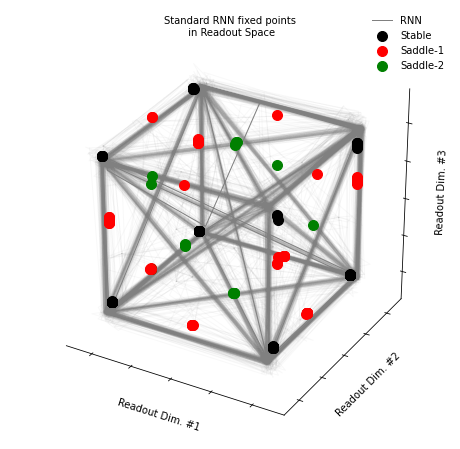

In [ ]:
num_fps_to_plot  = 200 #thin out number shown since this block takes a while to 
                       #compute and plot
apply_readout2 = get_apply_readout(params2)

fs = 10
alpha=0.05

ms=100

rnn_color = 'gray'
rnn_linewidth = 1

ntoplot = 256
nl_hiddens2 = np.reshape(rnn_internals2['nl_hiddens'][:ntoplot], (-1, n))



nlh_readout2 = apply_readout2(nl_hiddens2)
fps_readout2 = apply_readout2(fps2)
axlabel1 = 'Readout Dim. #1'
axlabel2 = 'Readout Dim. #2'
axlabel3 = 'Readout Dim. #3'
title = 'Standard RNN fixed points\n in Readout Space'

fig = plt.figure(figsize=(8,8))

ax = plt.axes(projection='3d')


nexamples = ntoplot
for eidx in range(nexamples):
    start_idx = eidx * ntimesteps
    stop_idx = (eidx + 1) * ntimesteps
    ax.plot3D(nlh_readout2[start_idx:stop_idx,0], nlh_readout2[start_idx:stop_idx,1], 
              nlh_readout2[start_idx:stop_idx,2], color=rnn_color, 
              alpha=alpha,linewidth = rnn_linewidth)
    
ax.plot3D(nlh_readout2[start_idx:stop_idx,0], nlh_readout2[start_idx:stop_idx,1], 
          nlh_readout2[start_idx:stop_idx,2], label='RNN',alpha=1,
          color=rnn_color,linewidth = rnn_linewidth)


key, skey = jax.random.split(key)
es = jax.random.choice(skey, np.arange(fps2.shape[0]),
                       shape=(num_fps_to_plot,), replace=False) 


eps = 0.0
for i in es:
  uhstar_jac = num_fps.compute_jacobians(rnn_fun_h2, fps2[i][None,...])
  uhstar_eig_decomps = num_fps.compute_eigenvalue_decomposition(uhstar_jac, 
                                                                'real')
  decomp = uhstar_eig_decomps[0]

  
  if np.sum(decomp['evals'].real>(1+eps))==0:
      ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
      s=ms, color='black');

  elif np.sum(decomp['evals'].real>(1+eps))==1:
      ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
              s=ms, color='red');
  elif np.sum(decomp['evals'].real>(1+eps))==2:
      ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
              s=ms, color='green');


i=0
ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
        s=ms, color='black', label='Stable');
ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
              s=ms, color='red', label='Saddle-1');
ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
        s=ms, color='green', label='Saddle-2');

readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3,fs)



We observe the standard GRU learns a very different fixed point solution than the GRU co-trained with the JSLDS.

### Standard GRU linearized dynamics generation

To generate dynamics trajectories for a standard RNN, we have to linearize around the numerical fixed points. As discussed in the paper, since there is no exact link between the numerical fixed points and points in state space, we have to employ some decision criteria. Here we just choose the closest fixed point.

In [ ]:
def get_nearest_fp(fps, ha_tm1):
  """Helper function to find the nearest fixed point to our current point 
  in state space"""
  euc_dists = np.sqrt(np.sum((fps-ha_tm1)**2, axis=1))
  return fps[np.argmin(euc_dists)]

#Compute pca on the standard GRU hidden states.
pca2 = PCA(n_components=2).fit(rnn_internals2['nl_hiddens'].reshape(-1,n))
h_pca2 = pca2.transform(rnn_internals2['nl_hiddens'].reshape(-1,n))

First, we try to fully simulate the dynamics forward for the entire trajectory.

Text(0.5, 1.0, 'Trial 7 Linearized approximation\n simulating dynamics forward')

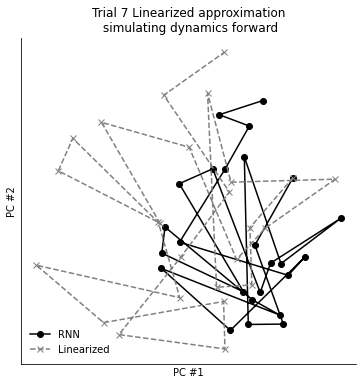

In [ ]:
# try to run all the way
trial = 7
x_star = np.zeros(u)
h_approxs = np.zeros((ntimesteps, n))
ha_tm1 = rnn_internals2['nl_hiddens'][trial, 0] #start with intial RNN state
h_approxs[0] = ha_tm1
for i in range(1,ntimesteps):
  h_star = get_nearest_fp(fps2, ha_tm1) #get nearest fixed point
  ha_tm1= JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, x_star, 
                                  ha_tm1, rnn_internals2['inputs'][trial,i], 1)
  h_approxs[i] = ha_tm1

h_approxs_pca = pca2.transform(h_approxs)


plt.figure(figsize=(6,6))
start_idx = trial*25
stop_idx = trial*25+25

ax=plt.subplot(111)
ax.plot(h_pca2[start_idx:stop_idx,0], h_pca2[start_idx:stop_idx,1], '-o',
        color='black', label='RNN')
ax.plot(h_approxs_pca[:,0], h_approxs_pca[:,1], '--x', color='gray', 
        label='Linearized')
pca_plot_settings(ax,fs)
plt.title('Trial {} Linearized approximation\n simulating dynamics forward'.format(trial))

We see that the linearized dynamics accumulate errors each timestep and for most trials  diverge significantly. So instead we resort to one-step ahead dynamics generation. For each state update of the trajectory, we provide the linearized state update equation the true previous state of the RNN. 

Text(0.5, 1.0, 'Trial 7 Linearized approximation\n one-step ahead dynamics generation')

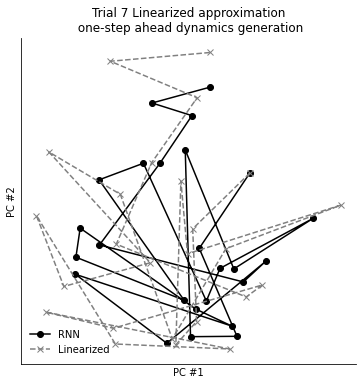

In [ ]:
#One step ahead dynamics generation
trial = 7
x_star = np.zeros(u)
h_approxs = np.zeros((ntimesteps, n))
ha_tm1 = rnn_internals2['nl_hiddens'][trial, 0] #start with initial RNN state
h_approxs[0] = ha_tm1
for i in range(1,ntimesteps):
  h_star = get_nearest_fp(fps2, ha_tm1) #get nearest fixed point
  h_approxs[i] = JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, 
                                         x_star, 
                                  ha_tm1, rnn_internals2['inputs'][trial,i], 1)
  ha_tm1 = rnn_internals2['nl_hiddens'][trial, i] #use true current state

h_approxs_pca = pca2.transform(h_approxs)


plt.figure(figsize=(6,6))
start_idx = trial*ntimesteps
stop_idx = trial*ntimesteps+ntimesteps

ax=plt.subplot(111)
ax.plot(h_pca2[start_idx:stop_idx,0], h_pca2[start_idx:stop_idx,1], '-o', 
        color='black', label='RNN')
ax.plot(h_approxs_pca[:,0], h_approxs_pca[:,1], '--x', color='gray',
        label='Linearized')
pca_plot_settings(ax,fs)
plt.title('Trial {} Linearized approximation\n one-step ahead dynamics generation'.format(trial))

This is better, but still not great compared to the JSLDS approximation (which fully simulates the dynamics forward) displayed above.

Now we compute the mean squared error of the one-step ahead dynamics approximation for an evaluation batch of held-out trials. This code block is a bit slow.

In [ ]:
x_star = np.zeros(u)
h_approxs = np.zeros((batch_size, ntimesteps, n))

for b in range(batch_size):
    ha_tm1 = rnn_internals2['nl_hiddens'][b, 0] #start with initial RNN state
    h_approxs[b,0] = ha_tm1

    for i in range(1,ntimesteps):
      h_star = get_nearest_fp(fps2, ha_tm1) #get nearest fixed point
      h_approxs[b,i] = JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, 
                                               x_star, 
                                      ha_tm1, rnn_internals2['inputs'][b,i], 1)
      ha_tm1 = rnn_internals2['nl_hiddens'][b, i] #use true current state

#don't include first state since it is given
approx_mse2 = np.sum((h_approxs[:,1:]-rnn_internals2['nl_hiddens'][:,1:])**2)/(
                                                    batch_size*(ntimesteps-1)*n)
print('Standard linearized RNN evaluation batch MSE: {0:.4}'.format(approx_mse2))
print('JSLDS evaluation batch MSE: {0:.4}'.format(approx_mse))

Standard linearized RNN evaluation batch MSE: 0.03757
JSLDS evaluation batch MSE: 0.000222


We compare this one-step ahead linearized dynamics MSE to the fully simulated JSLDS MSE (calculated earlier in this notebook). The JSLDS provides a large reduction in error and allows for simulating an entire trajectory accurately.